# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [2]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [4]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    return (y_true - y_predicted) @ (y_true - y_predicted) / len(y_true)

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    u = np.sum((y_true - y_predicted) ** 2)
    v = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - u / v

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [5]:
class NormalLR:
    def __init__(self):
        pass
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        w = np.linalg.inv(X.T @ X) @ X.T @ y
        self.w = w
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return X @ self.w

In [6]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [7]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.011511078866669164, R2: 0.9978926028594384


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течение `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [8]:
class GradientLR:
    def __init__(self, alpha:float, iterations=10000, l=0.):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        w = np.zeros(X.shape[1])
        
        for _ in range(self.iterations):
            grad = 2 * X.T @ (X @ w - y) / X.shape[0] + self.l * np.sign(w)
            w = w - self.alpha * grad
            
        self.w = w

    def predict(self, X:np.ndarray):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return X @ self.w

In [9]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.002, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [10]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

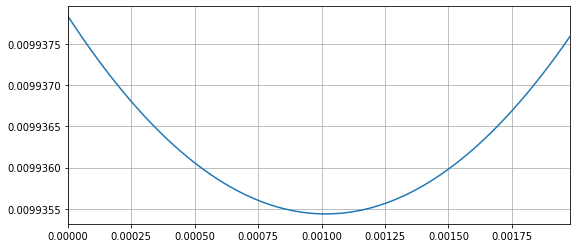

In [11]:
build_plot(X_train, y_train, X_val, y_val)

In [12]:
regr = GradientLR(0.1, iterations=10000, l=0.001)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.010266274614123154, R2: 0.9977809447460886


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [13]:
X, y = read_data()
X_scaler, y_scaler = StandardScaler(), StandardScaler()
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

# Scaling X data
X_train = X_scaler.fit_transform(X_train)
X_val, X_test = X_scaler.transform(X_val), X_scaler.transform(X_test)

# Scaling y data
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_val = y_scaler.transform(y_val.reshape(-1, 1)).reshape(-1)
y_test = y_scaler.transform(y_test.reshape(-1, 1)).reshape(-1)

In [14]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.23282389617580324, R2: 0.6461335821761058


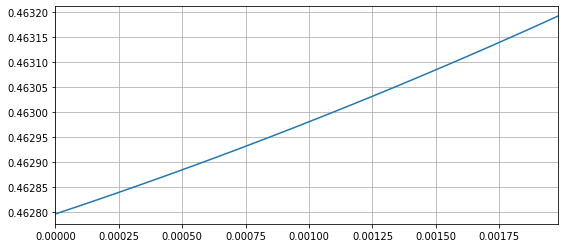

In [15]:
build_plot(X_train, y_train, X_val, y_val)

In [17]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.23282389617580324, R2: 0.6461335821761057


### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

Посмотрим на столбцы файла `boston.csv`.

1. crim     per capita crime rate by town
2. zn       proportion of residential land zoned for lots over 25,000 sq.ft.
3. indus    proportion of non-retail business acres per town
4. chas     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. nox      nitric oxides concentration (parts per 10 million)
6. rm       average number of rooms per dwelling
7. age      proportion of owner-occupied units built prior to 1940
8. dis      weighted distances to five Boston employment centres
9. rad      index of accessibility to radial highways
10. tax      full-value property-tax rate per 10,000 USD
11. ptratio  pupil-teacher ratio by town
12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. lstat    % lower status of the population

Посмотрим на веса регрессии.

In [24]:
headers = [
    "1. (crim) per capita crime rate by town",
    "2. (zn) proportion of residential land zoned for lots over 25,000 sq.ft.",
    "3. (indus) proportion of non-retail business acres per town", 
    "4. (chas) Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)",
    "5. (nox) nitric oxides concentration (parts per 10 million)",
    "6. (rm) average number of rooms per dwelling",
    "7. (age) proportion of owner-occupied units built prior to 1940",
    "8. (dis) weighted distances to five Boston employment centres",
    "9. (rad) index of accessibility to radial highways",
    "10. (tax) full-value property-tax rate per 10,000 USD",
    "11. (ptratio) pupil-teacher ratio by town",
    "12. (b) 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town",
    "13. (lstat) % lower status of the population",
]

In [25]:
regr.w[1:]

array([-0.08491211,  0.1255279 ,  0.03320039,  0.05093445, -0.22558412,
        0.29821724, -0.00468269, -0.3402242 ,  0.2307551 , -0.19848539,
       -0.23896504,  0.06907824, -0.42042408])

In [26]:
result = sorted(zip(regr.w[1:], headers), key=lambda pair: pair[0], reverse=True)
for weight, feature in result:
    print(f"{weight}, {feature}")

0.2982172350232625, 6. (rm) average number of rooms per dwelling
0.2307551033234405, 9. (rad) index of accessibility to radial highways
0.12552790402383207, 2. (zn) proportion of residential land zoned for lots over 25,000 sq.ft.
0.06907824131591137, 12. (b) 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
0.050934446523524635, 4. (chas) Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
0.033200387354501454, 3. (indus) proportion of non-retail business acres per town
-0.0046826881477026365, 7. (age) proportion of owner-occupied units built prior to 1940
-0.08491210699639683, 1. (crim) per capita crime rate by town
-0.19848538949002928, 10. (tax) full-value property-tax rate per 10,000 USD
-0.22558411506760076, 5. (nox) nitric oxides concentration (parts per 10 million)
-0.2389650416618566, 11. (ptratio) pupil-teacher ratio by town
-0.3402241963133509, 8. (dis) weighted distances to five Boston employment centres
-0.42042408465400566, 13. (lstat) % lowe

Положительное влияние в порядке уменьшения весов (от самых значимых до незначимых):
- Среднее количество комнат в доме
- Доступность магистралей
- Доля земли под жилую застройку
- Индекс, связанный с количеством афроамериканцев
- Наличие реки
- Доля земли, которая не относится к розничной торговле

Отрицательное влияние в порядке возрастания весов (от самых значимых до незначимых):
- Процент населения с низким статусом
- Расстояние до 5 бостонских центров занятости
- Соотношение учеников-учителей
- Содержание углекислого газа
- Ставка налога на имущество
- Уровень преступности по городам
- Доля домов, построенных до 1940